In [3]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [4]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [8]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2_j*y_mat*z_mat for λ_2_j in λ_2])
    dd_Λ = np.array([λ_2_j*np.ones_like(y_mat) for λ_2_j in λ_2])
    d_Λ_yz_sigma = d_Λ*y_mat*np.sqrt(z_mat)*σ_2
    d_Λ_z = d_Λ*z_mat
    mean_reversion = - y_mat*ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    std_y = y_mat*std
    variance = z_mat*y_mat**2*σ_2**2

    π = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    h = - (η-1.) / ξ_m * np.sum(π*d_Λ_yz_sigma, axis=0)
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = d_Λ*(z_mat*e + mean_reversion + std_y*h) + 0.5*dd_Λ*variance
        log_π_ratio = -(η-1.)*temp/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        h = - (v0_dz*std + (η-1)*np.sum(π*d_Λ_yz_sigma, axis=0)) / ξ_m
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [44]:
# Model parameters
η = .032
# ξ_m = .00256
ξ_m = .1
ξ_a = .1
# ξ_m = 1000.
# ξ_a = 1000.
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = np.array([0.0022*2, (0.0022+0.0197)*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [45]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.1205255531042464; RHS Error 0.2136759154015478
Iteration 2: LHS Error: 0.1618078523063553; RHS Error 0.19361752430232684
Iteration 3: LHS Error: 0.12315089732616835; RHS Error 0.14658727553034837
Iteration 4: LHS Error: 0.10807244372355496; RHS Error 0.6415930434271475
Iteration 5: LHS Error: 0.8352641608273508; RHS Error 0.5450864628648964
Iteration 6: LHS Error: 0.41134586226336456; RHS Error 0.2812260960254904
Iteration 7: LHS Error: 0.6442146734381042; RHS Error 0.8429436570599894
Iteration 8: LHS Error: 0.38953442081927414; RHS Error 0.8094993851773999
Iteration 9: LHS Error: 0.4718341025836288; RHS Error 1.2087049507343541
Iteration 10: LHS Error: 0.2461641371679435; RHS Error 0.3976061479082767
Iteration 11: LHS Error: 0.4393746667148011; RHS Error 0.35508707159098435
Iteration 12: LHS Error: 0.35809935571052387; RHS Error 0.6159371562683553
Iteration 13: LHS Error: 0.48188725517977504; RHS Error 5.7155000742652575
Iteration 14: LHS Error: 0.11512950621

KeyboardInterrupt: 

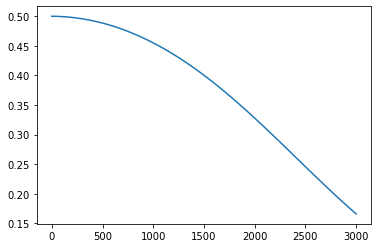

In [39]:
plt.plot(y_grid, π_grid[0,25])

In [33]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [35]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)

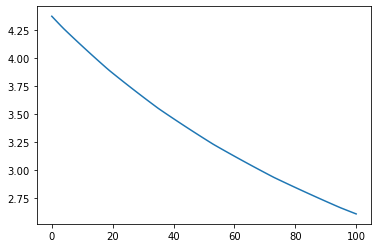

In [36]:
plt.plot(Et)

In [20]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [21]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

Text(0.5, 0, 'Year')

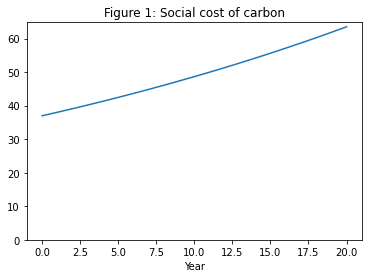

In [123]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [61]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

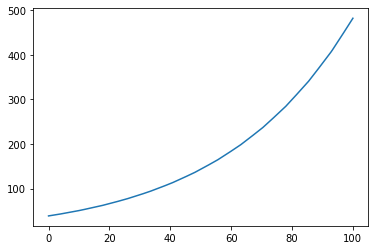

In [40]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [45]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [102]:
(1-δ/(α-ioverk))/ioverk

6.666666666666668

In [114]:
-0.0429 + ioverk - κ/2.*ioverk**2

0.02009865

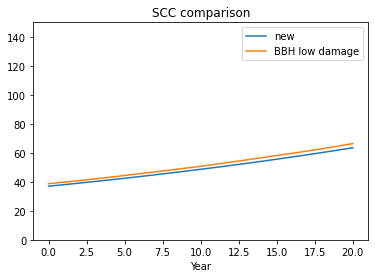

In [124]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

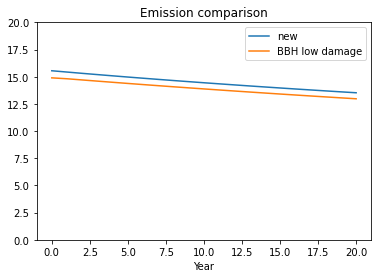

In [71]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [66]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])